In [1]:
#%reload_ext autoreload
#%autoreload 2


In [1]:
import torch
import torchvision
import torch.optim as optim
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.utils import save_image
#matplotlib.style.use('ggplot')

matplotlib.style.use('default')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import os

os.chdir('/home/axtr7550/Chromosome_project/cellbgnet/')
import cellbgnet
import cellbgnet.utils

from cellbgnet.datasets import DataSimulator
from cellbgnet.utils.hardware import cpu, gpu
from cellbgnet.model import CellBGModel
from cellbgnet.simulation.psf_kernel import SMAPSplineCoefficient
from cellbgnet.generic.emitter import EmitterSet
from cellbgnet.train_loss_infer import generate_probmap_cells

import cellbgnet
import cellbgnet.utils
from cellbgnet.datasets import DataSimulator
from cellbgnet.utils.hardware import cpu, gpu
from cellbgnet.model import CellBGModel
from cellbgnet.utils.plot_funcs import plot_od, plot_train_record

os.chdir('/home/axtr7550/Chromosome_project/cellbgnet/Axel_notebook/VAE_tutorial/src')

from skimage.io import imread
from skimage.measure import label
import random
import edt
from skimage.filters import gaussian
from scipy.ndimage import rotate
import random
import pickle
import pathlib
from pathlib import Path
#%matplotlib qt5


In [3]:
model_path = Path('/home/axtr7550/Chromosome_project/real_images/for_axel/model_rotated_45_venus_long_run.pkl')

In [4]:
with open(model_path, 'rb') as f:
    chromo_model = pickle.load(f)

INITIATING CPU IMPLEMENTATION


In [5]:
chromo_model.evaluation_params['eval_imgs'].shape

(30, 1041, 1302)

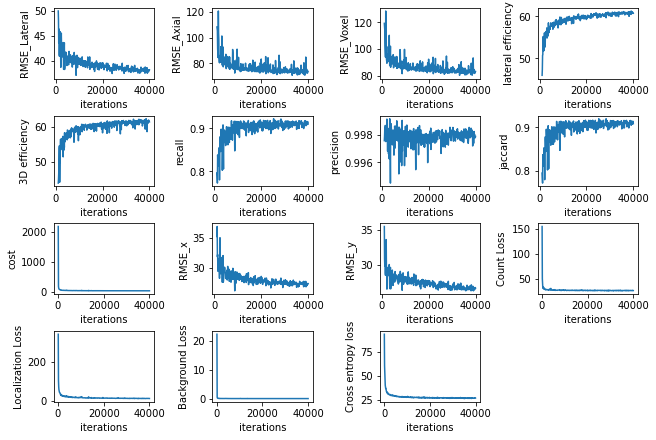

In [6]:
plot_train_record(chromo_model)

#### Photon count range, get background average from simulation using model paramteres

In [7]:
mol_photons = (chromo_model.data_generator.simulation_params['min_photon'] + 1) /2 * chromo_model.data_generator.psf_params['photon_scale']

In [9]:
mol_photons

1875.0

#### Plot network outputs for the eval images after tiling and re-tiling of one eval image

In [18]:
from cellbgnet.analyze_eval import recognition, plot_full_img_predictions, assemble_full_img_predictions

In [19]:
eval_img = chromo_model.evaluation_params['eval_imgs']

In [20]:
eval_img.shape

(30, 1041, 1302)

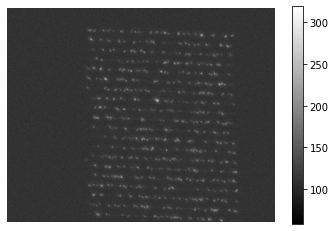

In [11]:
plt.figure()
plt.imshow(eval_img[0], cmap='gray')
plt.colorbar()
plt.axis('off')
plt.show()


In [12]:
fov_size = [eval_img.shape[2] * 65, eval_img.shape[1] * 65]

In [13]:
fov_size

[84630, 67665]

In [36]:
eval_img.mean(0).max()

149.4784014383952

In [37]:
eval_img.mean()

112.58867602261728

In [ ]:
preds_tmp, n_per_img, plot_data = recognition(model=chromo_model, eval_imgs_all=eval_img,
                                             batch_size=16, use_tqdm=False,
                                             nms=True, candidate_threshold=0.05,
                                             nms_threshold=0.05, 
                                             pixel_nm=chromo_model.data_generator.psf_params['pixel_size_xy'],
                                             plot_num=1,
                                             win_size=128,
                                             padding=True,
                                             start_field_pos=[0, 0],
                                             padded_background=chromo_model.evaluation_params['padded_background'])

In [16]:
plot_full_img_predictions(chromo_model, plot_infs=plot_data, eval_csv=None, plot_num=1, fov_size=fov_size, pixel_size=[65, 65])

In [17]:
img_infs = assemble_full_img_predictions(chromo_model, plot_data)

In [18]:
img_infs.keys()

dict_keys(['Probs', 'XO', 'YO', 'ZO', 'Int', 'BG', 'XO_sig', 'YO_sig', 'ZO_sig', 'Int_sig', 'Probs_ps', 'XO_ps', 'YO_ps', 'ZO_ps', 'Samples_ps', 'raw_img', 'only_bg'])

In [19]:
for key, value in img_infs.items():
    plt.figure()
    plt.imshow(value[400: 700, 500:800])
    plt.colorbar()
    plt.title(key)
    plt.show()

#### Testing real image

In [14]:
images_dir = Path('/home/axtr7550/Chromosome_project/real_images/for_axel/pool')
img_filenames = sorted(list(images_dir.glob('*.tif')))
img_filenames

[PosixPath('/home/axtr7550/Chromosome_project/real_images/for_axel/pool/Pos01_img_100.tif'),
 PosixPath('/home/axtr7550/Chromosome_project/real_images/for_axel/pool/Pos01_img_101.tif'),
 PosixPath('/home/axtr7550/Chromosome_project/real_images/for_axel/pool/Pos02_img_100.tif'),
 PosixPath('/home/axtr7550/Chromosome_project/real_images/for_axel/pool/Pos02_img_101.tif'),
 PosixPath('/home/axtr7550/Chromosome_project/real_images/for_axel/pool/Pos03_img_100.tif'),
 PosixPath('/home/axtr7550/Chromosome_project/real_images/for_axel/pool/Pos03_img_101.tif'),
 PosixPath('/home/axtr7550/Chromosome_project/real_images/for_axel/pool/Pos04_img_100.tif'),
 PosixPath('/home/axtr7550/Chromosome_project/real_images/for_axel/pool/Pos04_img_101.tif'),
 PosixPath('/home/axtr7550/Chromosome_project/real_images/for_axel/pool/Pos05_img_100.tif'),
 PosixPath('/home/axtr7550/Chromosome_project/real_images/for_axel/pool/Pos05_img_101.tif'),
 PosixPath('/home/axtr7550/Chromosome_project/real_images/for_axel/poo

In [15]:
img_path = Path('/mnt/sda1/SMLAT/data/real_data/chromosome_dots/pooled_8865/venus/Pos01_img_000000000.tiff')
mask_path = Path('/mnt/sda1/SMLAT/data/real_data/chromosome_dots/pooled_8865/phase_venus_mask/Pos01_img_000000000.png')



In [84]:
real_img = np.zeros((2, 2082, 1302))

for i in range(2):
    img_path = img_filenames[i]
    img = imread(img_path)[np.newaxis, :, :]
    img = img/1.3
    real_img[i, :, :] = img
    #mask_img = imread(mask_path)


In [85]:
real_img.shape

(2, 2082, 1302)

(-0.5, 1301.5, 2081.5, -0.5)

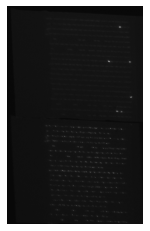

In [86]:
plt.imshow(real_img[0, ...], cmap='gray')
plt.axis('off')


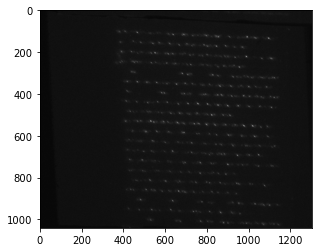

In [87]:
plt.imshow(real_img[0,real_img.shape[1]//2:,:], cmap='gray')
real_img = real_img[:,real_img.shape[1]//2:,:]

In [21]:
def get_img_infs(real_img_path, divisor=1.5):
    real_img = imread(real_img_path)[np.newaxis, :, :]
    real_img = real_img[:,real_img.shape[1]//2:,:]
    real_img = real_img/divisor

    preds_tmp, n_per_img, plot_data = recognition(model=chromo_model, eval_imgs_all=real_img,
                                                batch_size=16, use_tqdm=False,
                                                nms=True, candidate_threshold=0.2,
                                                nms_threshold=0.8, 
                                                pixel_nm=chromo_model.data_generator.psf_params['pixel_size_xy'],
                                                plot_num=1,
                                                win_size=128,
                                                padding=True,
                                                start_field_pos=[0, 0],
                                                padded_background=chromo_model.evaluation_params['padded_background'])
    img_infs = assemble_full_img_predictions(chromo_model, plot_data)
    return img_infs, plot_data


In [22]:
#%matplotlib qt5
inf_list = []
for i in range(20):
    img_path = img_filenames[i]
    print(img_path)
    img_infs, plot_data = get_img_infs(img_path)
    inf_list.append(img_infs)
    

    #plot_full_img_predictions(chromo_model, plot_infs=plot_data, eval_csv=None, plot_num=1,
                       # fov_size=fov_size, pixel_size=[65, 65])



/home/axtr7550/Chromosome_project/real_images/for_axel/pool/Pos01_img_100.tif
processing area:99/99, input field_xy:[1258 1301 1001 1040], use_coordconv:True, retain locs in area:[1278, 1301, 1021, 1040]
/home/axtr7550/Chromosome_project/real_images/for_axel/pool/Pos01_img_101.tif
processing area:99/99, input field_xy:[1258 1301 1001 1040], use_coordconv:True, retain locs in area:[1278, 1301, 1021, 1040]
/home/axtr7550/Chromosome_project/real_images/for_axel/pool/Pos02_img_100.tif
processing area:99/99, input field_xy:[1258 1301 1001 1040], use_coordconv:True, retain locs in area:[1278, 1301, 1021, 1040]
/home/axtr7550/Chromosome_project/real_images/for_axel/pool/Pos02_img_101.tif
processing area:99/99, input field_xy:[1258 1301 1001 1040], use_coordconv:True, retain locs in area:[1278, 1301, 1021, 1040]
/home/axtr7550/Chromosome_project/real_images/for_axel/pool/Pos03_img_100.tif
processing area:99/99, input field_xy:[1258 1301 1001 1040], use_coordconv:True, retain locs in area:[1278

In [440]:
%matplotlib inline

In [441]:
#%matplotlib qt5


In [485]:
for i in range(20):
    img_infs = inf_list[i]
    print(img_infs['raw_img'].mean())
    print(img_infs['raw_img'].std())

90.42796544934689
17.199670990213885
89.45270632190777
16.16674688592748
91.02092005550217
20.587962421263917
90.12530243626277
18.759318153547614
88.73148480157872
14.512777962682447
88.27383719128629
13.49557810435002
91.23861710819043
20.783773911303946
90.27530639578609
18.939848186092465
90.97758909788286
19.229073650598114
89.95195106127522
16.79248095253821
91.70712856842819
19.05136816710088
90.74916149100402
17.814449110338362
91.00947727897618
18.580422507706945
90.09347672218365
17.31084654923859
90.63179482487841
14.767663325511188
89.78307812852759
13.52116335402326
90.85029706262391
13.408898074889496
89.8356458425251
12.974188066553587
93.49720005135083
27.69101504492464
92.18477546059584
24.247536471605592


In [496]:
for i in range(20):
    fig, ax = plt.subplots()
    img_infs = inf_list[i]
    xy = np.where((img_infs['Probs_ps'] > 0))
    im = img_infs['raw_img']
    im = (im-im.mean())/im.std()
    plt.imshow(im, cmap='gray')
    plt.plot(xy[1], xy[0], 'r1')
    plt.show()

In [43]:
def get_xy_predictions(img_infs):

    # pick out pixels with probability greater than 0.2
    img_shape = img_infs['Probs_ps'].shape

    x_preds, y_preds = np.where(img_infs['Probs_ps']>0) 
    xy_predictions = np.concatenate((x_preds.reshape(-1,1), y_preds.reshape(-1,1)), axis=1)
    rows_to_remove = (xy_predictions[:,0] < 16)| (xy_predictions[:,1] < 16) | (xy_predictions[:,0] > img_shape[0]-16) | (xy_predictions[:,1] > img_shape[1]-16)
    print(xy_predictions.shape)
    xy_predictions = np.delete(xy_predictions, rows_to_remove, axis=0)

    if False:
    # Remove images that are too close to each other.
        i=0
        while i < xy_predictions.shape[0]:
            dist = np.abs(xy_predictions -xy_predictions[i,:]) 
            to_remove = np.where(np.logical_and.reduce((dist < 20),1))[0]
            if len(to_remove) > 1:

                xy_predictions = np.delete(xy_predictions, to_remove, axis=0)

                i -= 1
            i += 1

    return xy_predictions

In [49]:
predictions_list = []

for i in range(20):
    if i not in [14, 15]:
        xy_predictions = get_xy_predictions(inf_list[i])
        predictions_list.append(xy_predictions)
    else: 
        predictions_list.append([])


(328, 2)
(298, 2)
(354, 2)
(335, 2)
(246, 2)
(197, 2)
(370, 2)
(343, 2)
(406, 2)
(351, 2)
(349, 2)
(299, 2)
(338, 2)
(305, 2)
(178, 2)
(163, 2)
(464, 2)
(422, 2)


In [51]:

# Flip through pairs of images
for index1, index2 in [(i, i+1-2*(i%2)) for i in range(20)]:
    i=0
    xy_predictions_0 = predictions_list[index1]
    xy_predictions_1 = predictions_list[index2]
    print(f'n: {len(xy_predictions_0)}, m: {len(xy_predictions_1)}')
    to_add = []
    while i < xy_predictions_0.shape[0]:
        dist = xy_predictions_1 -xy_predictions_0[i,:]
        dist = np.sqrt(dist[:,0]**2 + dist[:,1]**2)
        if dist.min() > 20:
            to_add.append(xy_predictions_0[i,:])
        i += 1
    if len(to_add) > 0:
        predictions_list[index2] = np.concatenate([predictions_list[index2], np.vstack(to_add)], axis=0 )


n: 328, m: 298
n: 308, m: 328
n: 354, m: 335
n: 340, m: 354
n: 244, m: 196
n: 239, m: 244
n: 370, m: 343
n: 351, m: 370
n: 405, m: 350
n: 382, m: 405
n: 348, m: 297
n: 311, m: 348
n: 336, m: 303
n: 310, m: 336
n: 30, m: 9
n: 39, m: 30
n: 178, m: 163
n: 179, m: 178
n: 463, m: 421
n: 431, m: 463


In [52]:
import pandas as pd
df = pd.DataFrame(columns = ['Image', "x", "y"])
for i in range(20):
    xyarray = predictions_list[i]
    df_to_add = pd.DataFrame({"Image":i, "x":xyarray[:,0], "y":xyarray[:,1]})

    df = pd.concat([df, df_to_add], axis=0)


In [53]:
df.to_csv("/home/axtr7550/Chromosome_project/real_images/for_axel/fork_outputs/positions_df.csv", index=False)

In [23]:
%matplotlib tk


In [32]:
fig = plt.figure(figsize=(20,30))
coords = []
def onclick(event):
    if event.dblclick:
        ix, iy = event.xdata, event.ydata
        coords.append((ix, iy))
        print(ix, iy)

cid = fig.canvas.mpl_connect('button_press_event', onclick)
imgplot = plt.imshow(inf_list[15]['raw_img'])
plt.show()

871.9766871491332 307.60776294951893
664.5132904360089 299.0596337116342
617.6398741309164 722.0796181888534
894.782925471621 450.38257338456117
790.6978454217481 818.9384545341312
942.2893952190261 312.0029664741499
690.452398156794 160.4201941145298
535.1017609698695 903.4071762295532
618.5621124905306 721.5949770160242


In [380]:

print(xy_predictions.shape)
img_infs = inf_list[1]
xy_predictions = predictions_list[1]
probs_s = img_infs['Probs_ps']
image = img_infs['raw_img']


(155, 2)


In [31]:
coords_14 = coords.copy()
coords_14


[(397.3934483851344, 98.34273299454489),
 (438.8378911736749, 100.31000829091018),
 (496.8296004990126, 101.70076163428422),
 (556.989157270706, 107.18585599979933),
 (750.254406946542, 115.051056101857),
 (969.1901199987817, 123.66370720603433),
 (576.3716644961319, 156.01532343146457),
 (692.8033997579444, 160.54730441542816),
 (748.7120845359303, 160.78684462441694),
 (809.4115734936921, 162.3199019619453),
 (877.0577285121292, 166.24836138936166),
 (937.0385968429248, 168.4042232702609),
 (666.5545665469367, 300.26169781038476),
 (721.6317045994329, 301.7502691091008),
 (774.02941431424, 304.5785545766614),
 (774.02941431424, 304.5785545766614),
 (824.2438861242633, 304.7770307498236),
 (871.7293105533074, 306.7121734381546),
 (940.9478759436065, 311.6740777672082),
 (999.944918416055, 314.9489346243837),
 (1110.3969087807898, 319.1169342607887),
 (720.2208127684889, 770.6777753287099),
 (864.4719266215444, 776.330924260846),
 (949.3649766871752, 781.0259123570265),
 (1005.80064992

In [58]:
img_infs = inf_list[0]

image = img_infs['raw_img']
plt.imshow(image, cmap='gray')

In [33]:
coords_15 = coords.copy()
coords_15


[(871.9766871491332, 307.60776294951893),
 (664.5132904360089, 299.0596337116342),
 (617.6398741309164, 722.0796181888534),
 (894.782925471621, 450.38257338456117),
 (790.6978454217481, 818.9384545341312),
 (942.2893952190261, 312.0029664741499),
 (690.452398156794, 160.4201941145298),
 (535.1017609698695, 903.4071762295532),
 (618.5621124905306, 721.5949770160242)]

In [50]:
xy_predictions_14 = np.array([[val[0] for val in coords_14],[val[1] for val in coords_14]])
xy_predictions_14 = xy_predictions_14.reshape(-1, 2)
predictions_list[14] = xy_predictions_14

xy_predictions_15 = np.array([[val[0] for val in coords_15],[val[1] for val in coords_15]])
xy_predictions_15 = xy_predictions_15.reshape(-1, 2)
predictions_list[15] = xy_predictions_15


372
17 1103


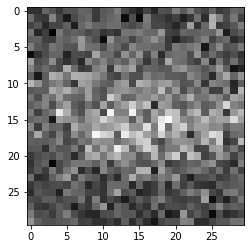

In [103]:
img_infs = inf_list[1]
probs_s = img_infs['Probs_ps']
print(len(x_preds))
image = img_infs['raw_img']
index = 0

x_prediction = x_preds[index]
y_prediction = y_preds[index]
offset = 15
roi = image[x_prediction-offset:x_prediction+offset, y_prediction-offset:y_prediction+offset]

plt.imshow(roi, cmap='gray')
print(x_prediction, y_prediction)


In [289]:
xy_predictions = np.concatenate((x_preds.reshape(-1,1), y_preds.reshape(-1,1)), axis=1)
for i in range(xy_predictions.shape[0]):
    dist = xy_predictions -xy_predictions[i,0] 
    

(207, 2)


In [65]:
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import Layout
%matplotlib inline

In [ ]:
slider =widgets.IntSlider(
    min=0,
    max=len(xy_predictions),
    step=1,
    description='Slider:',
    value=0
)


In [68]:
def on_value_changed(val):
    with out:
        n = slider.value
        offset = 12
        x_prediction, y_prediction = xy_predictions[n,0], xy_predictions[n,1] 
        out.clear_output()

        roi = image[x_prediction-offset:x_prediction+offset, y_prediction-offset:y_prediction+offset]
        plt.imshow(roi, cmap='gray')
        plt.show()

        print(f'x,y: ({x_prediction},{y_prediction})')# P:{probs_s[x_prediction, y_prediction]:.2f}')


out = widgets.Output(layout=Layout(width='70%', height='300px'))
on_value_changed(0)


slider.observe(on_value_changed, names='value')


In [70]:
display(out)
display(slider)


Output(layout=Layout(height='300px', width='70%'), outputs=({'output_type': 'display_data', 'data': {'text/pla…

IntSlider(value=22, description='Slider:', max=421)

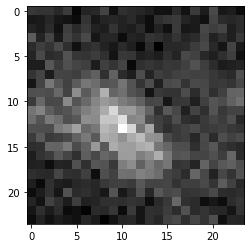

In [76]:
n = 13

x_prediction, y_prediction = xy_predictions[n,0], xy_predictions[n,1] 

offset = 12
roi = image[x_prediction-offset:x_prediction+offset, y_prediction-offset:y_prediction+offset]
plt.imshow(roi, cmap='gray')


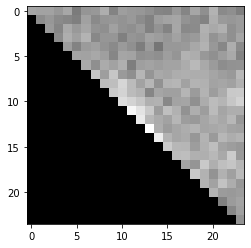

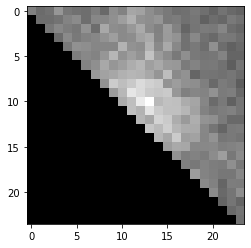

In [91]:
upper = torch.triu((torch.tensor(roi)))
lower = torch.transpose(torch.tril((torch.tensor(roi))))
plt.imshow(, cmap='gray')
plt.show()
plt.imshow(, 0,1), cmap='gray')


#### Predictions are a list of numbers where each element corresponds to a localizaiton in the following order


    1. counter of the molecule per tile.. not a global counter on the frame, need to fix this
    2. image number used to index into the number of the image in the prediction arrays.
    Eval image is of shape [1, 1041, 1302], so, the image number will always be 1, if you give one image at a time
    3. x position in nm where 0 is top left corner
    4. y position in nm where 0 is top left corner
    5. z position in nm where 0 is from the reference 0 nm in height
    6. photon counts 
    7. probability afer nms
    8. x_sigma in nm 
    9. y_sigma in nm
    10. z_sigma in nm
    11. photon_counts_sigma
    12. x offset
    13. y offset


In [21]:
preds_tmp

[[1.0,
  1.0,
  28321.5390625,
  6723.5126953125,
  231.839599609375,
  1255.1942138671875,
  0.6568737626075745,
  13.57247543334961,
  19.955181121826172,
  63.516578674316406,
  273.5525817871094,
  0.21598798036575317,
  -0.06134552136063576],
 [2.0,
  1.0,
  31802.8359375,
  6725.31005859375,
  413.4086608886719,
  2310.737060546875,
  0.6244803667068481,
  28.462249755859375,
  23.14813804626465,
  41.45981216430664,
  335.16925048828125,
  -0.22561213374137878,
  -0.033694442361593246],
 [3.0,
  1.0,
  29890.365234375,
  6743.890625,
  481.10693359375,
  1487.901123046875,
  0.24742525815963745,
  64.95372772216797,
  55.89762496948242,
  13.929397583007812,
  295.5343017578125,
  0.3517780005931854,
  -0.7478349208831787],
 [4.0,
  1.0,
  33122.10546875,
  6842.93896484375,
  386.67425537109375,
  1144.3037109375,
  0.2555111050605774,
  64.86029815673828,
  44.50193405151367,
  55.326412200927734,
  188.57318115234375,
  0.07084576785564423,
  -0.2240137755870819],
 [5.0,
  1.

In [23]:
img_infs = assemble_full_img_predictions(chromo_model, plot_data)

In [24]:
img_infs.keys()

dict_keys(['Probs', 'XO', 'YO', 'ZO', 'Int', 'BG', 'XO_sig', 'YO_sig', 'ZO_sig', 'Int_sig', 'Probs_ps', 'XO_ps', 'YO_ps', 'ZO_ps', 'Samples_ps', 'raw_img', 'only_bg'])

In [25]:
for key, value in img_infs.items():
    plt.figure()
    plt.imshow(value[400: 700, 500:800])
    plt.colorbar()
    plt.title(key)
    plt.show()

In [23]:
plt.figure()
plt.imshow(img_infs['BG'][400: 700, 500:800], vmin=0, vmax=300, cmap='gray')
plt.colorbar()
plt.title('Predicted PSF')
plt.show()

In [24]:
plt.figure()
plt.imshow(img_infs['raw_img'][400: 700, 500:800], vmin=25, vmax=520 , cmap='gray')
plt.colorbar()
plt.title('Raw image')
plt.show()

In [51]:
plt.figure()
plt.imshow(img_infs['only_bg'][:-200, :-200])
plt.colorbar()
plt.title('Only bg')
plt.show()

##### Collect predictions of all emitters in one image for plotting distributions

In [27]:
x_global = np.array([x[2] for x in preds_tmp])
y_global = np.array([x[3] for x in preds_tmp])
z_global = np.array([x[4] for x in preds_tmp])
ph_global = np.array([x[5] for x in preds_tmp])
prob_dot_nms = np.array([x[6] for x in preds_tmp])
sigma_x = np.array([x[7] for x in preds_tmp])
sigma_y = np.array([x[8] for x in preds_tmp])
sigma_z = np.array([x[9] for x in preds_tmp])
sigma_ph = np.array([x[10] for x in preds_tmp])

#### Only plot z, photon counts and probablitiy so that you can check what is going on as time goes by

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].hist(z_global, bins=50)
ax[0].axvspan(z_global.min(), z_global.max(), color='green', alpha=0.1)
ax[0].set_xlabel('z [nm] of the predicted emitters')
ax[0].set_ylabel('counts')

ax[1].hist(ph_global, bins=50)
ax[1].axvspan(ph_global.min(), ph_global.max(), color='green', alpha=0.1)
ax[1].set_xlabel('photon counts of the predicted emitters')
ax[1].set_ylabel('counts')

plt.suptitle(img_path)
plt.show()

### Plotting sigma-xyzi distributions of a single image (sigmas) predicted by the network

In [29]:

fig, ax = plt.subplots(nrows=2, ncols=2)
ax[0, 0].hist(sigma_x, bins=25)
ax[0, 0].axvspan(sigma_x.min(), sigma_x.max(), color='green', alpha=0.1)
ax[0, 0].set_xlabel(r'$\sigma_x$ [nm]')
ax[0, 0].set_ylabel('counts')
ax[0, 0].set_title(f"Mean sigma_x is {np.mean(sigma_x):0.3f}, min:{np.min(sigma_x):0.3f}, max:{np.max(sigma_x):0.3f}")

ax[0, 1].hist(sigma_y, bins=25)
ax[0, 1].axvspan(sigma_y.min(), sigma_y.max(), color='green', alpha=0.1)
ax[0, 1].set_xlabel(r'$\sigma_y$ [nm]')
ax[0, 1].set_ylabel('counts')
ax[0, 1].set_title(f"Mean sigma_y is {np.mean(sigma_y):0.3f}, min:{np.min(sigma_y):0.3f}, max:{np.max(sigma_y):0.3f}")


ax[1, 0].hist(sigma_z, bins=25)
ax[1, 0].axvspan(sigma_z.min(), sigma_z.max(), color='green', alpha=0.1)
ax[1, 0].set_xlabel(r'$\sigma_z$ [nm]')
ax[1, 0].set_ylabel('counts')
ax[1, 0].set_title(f"Mean sigma_z is {np.mean(sigma_z):0.3f}, min:{np.min(sigma_z):0.3f}, max:{np.max(sigma_z):0.3f}")

ax[1, 1].hist(sigma_ph, bins=25)
ax[1, 1].axvspan(sigma_ph.min(), sigma_ph.max(), color='green', alpha=0.1)
ax[1, 1].set_xlabel(r'$\sigma_{ph}$ [nm]')
ax[1, 1].set_ylabel('counts')
ax[1, 1].set_title(f"Mean sigma_ph is {np.mean(sigma_ph):0.3f}, min:{np.min(sigma_ph):0.3f}, max:{np.max(sigma_ph):0.3f}")

plt.show()

#### Plot distributions on predictions in one image xyzi

##### Loop over all images and plot variability in time

In [28]:
img_filenames

[PosixPath('/mnt/sda1/SMLAT/data/real_data/chromosome_dots/pooled_3041_midway_pos32/venus/Pos32_img_000000000.tiff'),
 PosixPath('/mnt/sda1/SMLAT/data/real_data/chromosome_dots/pooled_3041_midway_pos32/venus/Pos32_img_000000001.tiff'),
 PosixPath('/mnt/sda1/SMLAT/data/real_data/chromosome_dots/pooled_3041_midway_pos32/venus/Pos32_img_000000002.tiff'),
 PosixPath('/mnt/sda1/SMLAT/data/real_data/chromosome_dots/pooled_3041_midway_pos32/venus/Pos32_img_000000003.tiff'),
 PosixPath('/mnt/sda1/SMLAT/data/real_data/chromosome_dots/pooled_3041_midway_pos32/venus/Pos32_img_000000004.tiff'),
 PosixPath('/mnt/sda1/SMLAT/data/real_data/chromosome_dots/pooled_3041_midway_pos32/venus/Pos32_img_000000005.tiff'),
 PosixPath('/mnt/sda1/SMLAT/data/real_data/chromosome_dots/pooled_3041_midway_pos32/venus/Pos32_img_000000006.tiff'),
 PosixPath('/mnt/sda1/SMLAT/data/real_data/chromosome_dots/pooled_3041_midway_pos32/venus/Pos32_img_000000007.tiff'),
 PosixPath('/mnt/sda1/SMLAT/data/real_data/chromosome_do

In [29]:
number_preds = []
for img_path in img_filenames:
    real_img = imread(img_path)[np.newaxis, :]
    preds_tmp, n_per_img, plot_data = recognition(model=chromo_model, eval_imgs_all=real_img,
                                             batch_size=16, use_tqdm=False,
                                             nms=True, candidate_threshold=0.05,
                                             nms_threshold=0.05, 
                                             pixel_nm=chromo_model.data_generator.psf_params['pixel_size_xy'],
                                             plot_num=1,
                                             win_size=128,
                                             padding=True,
                                             start_field_pos=[0, 0],
                                             padded_background=chromo_model.evaluation_params['padded_background'])
    number_preds.append(len(preds_tmp))
    print(img_path)

processing area:99/99, input field_xy:[1258 1301 1004 1043], use_coordconv:True, retain locs in area:[1278, 1301, 1024, 1043]
/mnt/sda1/SMLAT/data/real_data/chromosome_dots/pooled_3041_midway_pos32/venus/Pos32_img_000000000.tiff
processing area:99/99, input field_xy:[1258 1301 1004 1043], use_coordconv:True, retain locs in area:[1278, 1301, 1024, 1043]
/mnt/sda1/SMLAT/data/real_data/chromosome_dots/pooled_3041_midway_pos32/venus/Pos32_img_000000001.tiff
processing area:99/99, input field_xy:[1258 1301 1004 1043], use_coordconv:True, retain locs in area:[1278, 1301, 1024, 1043]
/mnt/sda1/SMLAT/data/real_data/chromosome_dots/pooled_3041_midway_pos32/venus/Pos32_img_000000002.tiff
processing area:99/99, input field_xy:[1258 1301 1004 1043], use_coordconv:True, retain locs in area:[1278, 1301, 1024, 1043]
/mnt/sda1/SMLAT/data/real_data/chromosome_dots/pooled_3041_midway_pos32/venus/Pos32_img_000000003.tiff
processing area:99/99, input field_xy:[1258 1301 1004 1043], use_coordconv:True, ret

processing area:99/99, input field_xy:[1258 1301 1004 1043], use_coordconv:True, retain locs in area:[1278, 1301, 1024, 1043]
/mnt/sda1/SMLAT/data/real_data/chromosome_dots/pooled_3041_midway_pos32/venus/Pos32_img_000000036.tiff
processing area:99/99, input field_xy:[1258 1301 1004 1043], use_coordconv:True, retain locs in area:[1278, 1301, 1024, 1043]
/mnt/sda1/SMLAT/data/real_data/chromosome_dots/pooled_3041_midway_pos32/venus/Pos32_img_000000037.tiff
processing area:99/99, input field_xy:[1258 1301 1004 1043], use_coordconv:True, retain locs in area:[1278, 1301, 1024, 1043]
/mnt/sda1/SMLAT/data/real_data/chromosome_dots/pooled_3041_midway_pos32/venus/Pos32_img_000000038.tiff
processing area:99/99, input field_xy:[1258 1301 1004 1043], use_coordconv:True, retain locs in area:[1278, 1301, 1024, 1043]
/mnt/sda1/SMLAT/data/real_data/chromosome_dots/pooled_3041_midway_pos32/venus/Pos32_img_000000039.tiff
processing area:99/99, input field_xy:[1258 1301 1004 1043], use_coordconv:True, ret

processing area:99/99, input field_xy:[1258 1301 1004 1043], use_coordconv:True, retain locs in area:[1278, 1301, 1024, 1043]
/mnt/sda1/SMLAT/data/real_data/chromosome_dots/pooled_3041_midway_pos32/venus/Pos32_img_000000072.tiff
processing area:99/99, input field_xy:[1258 1301 1004 1043], use_coordconv:True, retain locs in area:[1278, 1301, 1024, 1043]
/mnt/sda1/SMLAT/data/real_data/chromosome_dots/pooled_3041_midway_pos32/venus/Pos32_img_000000073.tiff
processing area:99/99, input field_xy:[1258 1301 1004 1043], use_coordconv:True, retain locs in area:[1278, 1301, 1024, 1043]
/mnt/sda1/SMLAT/data/real_data/chromosome_dots/pooled_3041_midway_pos32/venus/Pos32_img_000000074.tiff
processing area:99/99, input field_xy:[1258 1301 1004 1043], use_coordconv:True, retain locs in area:[1278, 1301, 1024, 1043]
/mnt/sda1/SMLAT/data/real_data/chromosome_dots/pooled_3041_midway_pos32/venus/Pos32_img_000000075.tiff
processing area:99/99, input field_xy:[1258 1301 1004 1043], use_coordconv:True, ret

processing area:99/99, input field_xy:[1258 1301 1004 1043], use_coordconv:True, retain locs in area:[1278, 1301, 1024, 1043]
/mnt/sda1/SMLAT/data/real_data/chromosome_dots/pooled_3041_midway_pos32/venus/Pos32_img_000000108.tiff
processing area:99/99, input field_xy:[1258 1301 1004 1043], use_coordconv:True, retain locs in area:[1278, 1301, 1024, 1043]
/mnt/sda1/SMLAT/data/real_data/chromosome_dots/pooled_3041_midway_pos32/venus/Pos32_img_000000109.tiff
processing area:99/99, input field_xy:[1258 1301 1004 1043], use_coordconv:True, retain locs in area:[1278, 1301, 1024, 1043]
/mnt/sda1/SMLAT/data/real_data/chromosome_dots/pooled_3041_midway_pos32/venus/Pos32_img_000000110.tiff
processing area:99/99, input field_xy:[1258 1301 1004 1043], use_coordconv:True, retain locs in area:[1278, 1301, 1024, 1043]
/mnt/sda1/SMLAT/data/real_data/chromosome_dots/pooled_3041_midway_pos32/venus/Pos32_img_000000111.tiff
processing area:99/99, input field_xy:[1258 1301 1004 1043], use_coordconv:True, ret

processing area:99/99, input field_xy:[1258 1301 1004 1043], use_coordconv:True, retain locs in area:[1278, 1301, 1024, 1043]
/mnt/sda1/SMLAT/data/real_data/chromosome_dots/pooled_3041_midway_pos32/venus/Pos32_img_000000144.tiff
processing area:99/99, input field_xy:[1258 1301 1004 1043], use_coordconv:True, retain locs in area:[1278, 1301, 1024, 1043]
/mnt/sda1/SMLAT/data/real_data/chromosome_dots/pooled_3041_midway_pos32/venus/Pos32_img_000000145.tiff
processing area:99/99, input field_xy:[1258 1301 1004 1043], use_coordconv:True, retain locs in area:[1278, 1301, 1024, 1043]
/mnt/sda1/SMLAT/data/real_data/chromosome_dots/pooled_3041_midway_pos32/venus/Pos32_img_000000146.tiff
processing area:99/99, input field_xy:[1258 1301 1004 1043], use_coordconv:True, retain locs in area:[1278, 1301, 1024, 1043]
/mnt/sda1/SMLAT/data/real_data/chromosome_dots/pooled_3041_midway_pos32/venus/Pos32_img_000000147.tiff
processing area:99/99, input field_xy:[1258 1301 1004 1043], use_coordconv:True, ret

processing area:99/99, input field_xy:[1258 1301 1004 1043], use_coordconv:True, retain locs in area:[1278, 1301, 1024, 1043]
/mnt/sda1/SMLAT/data/real_data/chromosome_dots/pooled_3041_midway_pos32/venus/Pos32_img_000000180.tiff
processing area:99/99, input field_xy:[1258 1301 1004 1043], use_coordconv:True, retain locs in area:[1278, 1301, 1024, 1043]
/mnt/sda1/SMLAT/data/real_data/chromosome_dots/pooled_3041_midway_pos32/venus/Pos32_img_000000181.tiff
processing area:99/99, input field_xy:[1258 1301 1004 1043], use_coordconv:True, retain locs in area:[1278, 1301, 1024, 1043]
/mnt/sda1/SMLAT/data/real_data/chromosome_dots/pooled_3041_midway_pos32/venus/Pos32_img_000000182.tiff
processing area:99/99, input field_xy:[1258 1301 1004 1043], use_coordconv:True, retain locs in area:[1278, 1301, 1024, 1043]
/mnt/sda1/SMLAT/data/real_data/chromosome_dots/pooled_3041_midway_pos32/venus/Pos32_img_000000183.tiff
processing area:99/99, input field_xy:[1258 1301 1004 1043], use_coordconv:True, ret

processing area:99/99, input field_xy:[1258 1301 1004 1043], use_coordconv:True, retain locs in area:[1278, 1301, 1024, 1043]
/mnt/sda1/SMLAT/data/real_data/chromosome_dots/pooled_3041_midway_pos32/venus/Pos32_img_000000216.tiff
processing area:99/99, input field_xy:[1258 1301 1004 1043], use_coordconv:True, retain locs in area:[1278, 1301, 1024, 1043]
/mnt/sda1/SMLAT/data/real_data/chromosome_dots/pooled_3041_midway_pos32/venus/Pos32_img_000000217.tiff
processing area:99/99, input field_xy:[1258 1301 1004 1043], use_coordconv:True, retain locs in area:[1278, 1301, 1024, 1043]
/mnt/sda1/SMLAT/data/real_data/chromosome_dots/pooled_3041_midway_pos32/venus/Pos32_img_000000218.tiff
processing area:99/99, input field_xy:[1258 1301 1004 1043], use_coordconv:True, retain locs in area:[1278, 1301, 1024, 1043]
/mnt/sda1/SMLAT/data/real_data/chromosome_dots/pooled_3041_midway_pos32/venus/Pos32_img_000000219.tiff
processing area:99/99, input field_xy:[1258 1301 1004 1043], use_coordconv:True, ret

processing area:99/99, input field_xy:[1258 1301 1004 1043], use_coordconv:True, retain locs in area:[1278, 1301, 1024, 1043]
/mnt/sda1/SMLAT/data/real_data/chromosome_dots/pooled_3041_midway_pos32/venus/Pos32_img_000000252.tiff
processing area:99/99, input field_xy:[1258 1301 1004 1043], use_coordconv:True, retain locs in area:[1278, 1301, 1024, 1043]
/mnt/sda1/SMLAT/data/real_data/chromosome_dots/pooled_3041_midway_pos32/venus/Pos32_img_000000253.tiff
processing area:99/99, input field_xy:[1258 1301 1004 1043], use_coordconv:True, retain locs in area:[1278, 1301, 1024, 1043]
/mnt/sda1/SMLAT/data/real_data/chromosome_dots/pooled_3041_midway_pos32/venus/Pos32_img_000000254.tiff
processing area:99/99, input field_xy:[1258 1301 1004 1043], use_coordconv:True, retain locs in area:[1278, 1301, 1024, 1043]
/mnt/sda1/SMLAT/data/real_data/chromosome_dots/pooled_3041_midway_pos32/venus/Pos32_img_000000255.tiff
processing area:99/99, input field_xy:[1258 1301 1004 1043], use_coordconv:True, ret

processing area:99/99, input field_xy:[1258 1301 1004 1043], use_coordconv:True, retain locs in area:[1278, 1301, 1024, 1043]
/mnt/sda1/SMLAT/data/real_data/chromosome_dots/pooled_3041_midway_pos32/venus/Pos32_img_000000288.tiff
processing area:99/99, input field_xy:[1258 1301 1004 1043], use_coordconv:True, retain locs in area:[1278, 1301, 1024, 1043]
/mnt/sda1/SMLAT/data/real_data/chromosome_dots/pooled_3041_midway_pos32/venus/Pos32_img_000000289.tiff
processing area:99/99, input field_xy:[1258 1301 1004 1043], use_coordconv:True, retain locs in area:[1278, 1301, 1024, 1043]
/mnt/sda1/SMLAT/data/real_data/chromosome_dots/pooled_3041_midway_pos32/venus/Pos32_img_000000290.tiff
processing area:99/99, input field_xy:[1258 1301 1004 1043], use_coordconv:True, retain locs in area:[1278, 1301, 1024, 1043]
/mnt/sda1/SMLAT/data/real_data/chromosome_dots/pooled_3041_midway_pos32/venus/Pos32_img_000000291.tiff
processing area:99/99, input field_xy:[1258 1301 1004 1043], use_coordconv:True, ret

In [32]:
plt.figure()
plt.plot(np.arange(0, len(number_preds)), number_preds)
plt.xlabel('Frame number')
plt.ylabel('Number of dots predicted')
plt.title('3041 midway')
plt.show()